<a href="https://colab.research.google.com/github/SFStefenon/SyntheticData4Classification/blob/main/Algorithm_SyntheticData4Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import torch
# Install torch geometric on Colab
try:
    import torch_geometric
except ModuleNotFoundError:
    # Installing torch geometric packages with specific CUDA + PyTorch version.
    TORCH = torch.__version__.split('+')[0]
    CUDA = 'cu' + torch.version.cuda.replace('.','')
    !pip install --quiet torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install --quiet torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install --quiet torch-geometric
    import torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.2 MB/s eta 0:00:00


In [2]:
# Libraries for NN
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
from collections import Counter

# Libraries for torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data
from torch_geometric.utils import homophily
import torch_geometric.utils as tgu
from torch_geometric.nn import GATConv
import torch_geometric.transforms as T
from torch_geometric.transforms import RandomNodeSplit
from torch_sparse import SparseTensor

# Libraries to plot
import matplotlib.pyplot as plt
import matplotlib.colors
from community import community_louvain

# Libraries for the benckmark
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import datasets

In [3]:
# Present the device that I'm using
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Generate the synthetic data

In [4]:
################################################################################
# Setup the base for the problem
n_samples = 100
n_features =  8

# Generate a community probability matrix for a given number of classes.
def generate_community_probs(n_classes, p, pp):
    return [[pp if i == j else p for j in range(n_classes)] for i in range(n_classes)]

for n_classes in range(2,9):
  # Generete the data for classification
  x_a, y_a = make_classification(n_samples=n_samples, n_features=n_features, n_classes=n_classes, n_informative=6, random_state=0)

  # Generete the data for classification more spaced (cluster)
  # x_a, y_a = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_classes, cluster_std=10, random_state=0)

  # Define the size of the communities/classes
  size_c = dict(Counter(y_a))       # Evaluate the distribution of the classes
  community_sizes = [0]*n_classes   # Create the vector for community_sizes
  for k in size_c:
    community_sizes[k] = size_c[k]  # Use the size of each class

  ################################################################################
  # Matrix of probabilities of communities

  p=0.0
  pp=1

  community_probs = generate_community_probs(n_classes, p, pp)

  # Generete the data for graphs
  G_sbm = nx.stochastic_block_model(community_sizes, community_probs, seed=0)

  # Sort the data based on the classes
  x_b = torch.Tensor(x_a[np.argsort(y_a)])
  y_b = torch.tensor(y_a[np.argsort(y_a)])
  edge_b = torch.tensor(np.transpose(np.asarray(list(G_sbm.edges))))

  # Save the data
  dataset = Data(x=x_b, edge_index=edge_b, y=y_b)

  ################################################################################
  # Percentage for the train
  per_train = 0.7
  num_train_per_class = int((n_samples * per_train)/n_classes)
  num_test = n_samples-(num_train_per_class*n_classes) # With this all samples not used for train are used for the test

  # Divide the data for train, val. and, test.
  transform = RandomNodeSplit(split='random', num_splits=1, num_train_per_class=num_train_per_class, num_val=0, num_test=num_test)
  data = transform(dataset)

  # Present the masks
  data.train_mask.sum(), data.val_mask.sum(), data.test_mask.sum()

  # Define the train, val., and test based on the masks
  train_graph = data.subgraph(data.train_mask)
  val_graph = data.subgraph(data.val_mask)
  test_graph = data.subgraph(data.test_mask)

  # Present the masks
  data.train_mask.sum(), data.val_mask.sum(), data.test_mask.sum()

  # Define the train, val., and test based on the masks
  train_graph = data.subgraph(data.train_mask)
  val_graph = data.subgraph(data.val_mask)
  test_graph = data.subgraph(data.test_mask)

  # For multiclasses (Save in different vectors)
  if (n_classes==2):
    x_b0 = torch.Tensor(x_a[np.argsort(y_a)])
    y_b0 = torch.tensor(y_a[np.argsort(y_a)])
  elif (n_classes==3):
    x_b1 = torch.Tensor(x_a[np.argsort(y_a)])
    y_b1 = torch.tensor(y_a[np.argsort(y_a)])
  elif (n_classes==4):
    x_b2 = torch.Tensor(x_a[np.argsort(y_a)])
    y_b2 = torch.tensor(y_a[np.argsort(y_a)])
  elif (n_classes==5):
    x_b3 = torch.Tensor(x_a[np.argsort(y_a)])
    y_b3 = torch.tensor(y_a[np.argsort(y_a)])
  elif (n_classes==6):
    x_b4 = torch.Tensor(x_a[np.argsort(y_a)])
    y_b4 = torch.tensor(y_a[np.argsort(y_a)])
  elif (n_classes==7):
    x_b5 = torch.Tensor(x_a[np.argsort(y_a)])
    y_b5 = torch.tensor(y_a[np.argsort(y_a)])
  else:
    x_b6 = torch.Tensor(x_a[np.argsort(y_a)])
    y_b6 = torch.tensor(y_a[np.argsort(y_a)])

<function matplotlib.pyplot.show(close=None, block=None)>

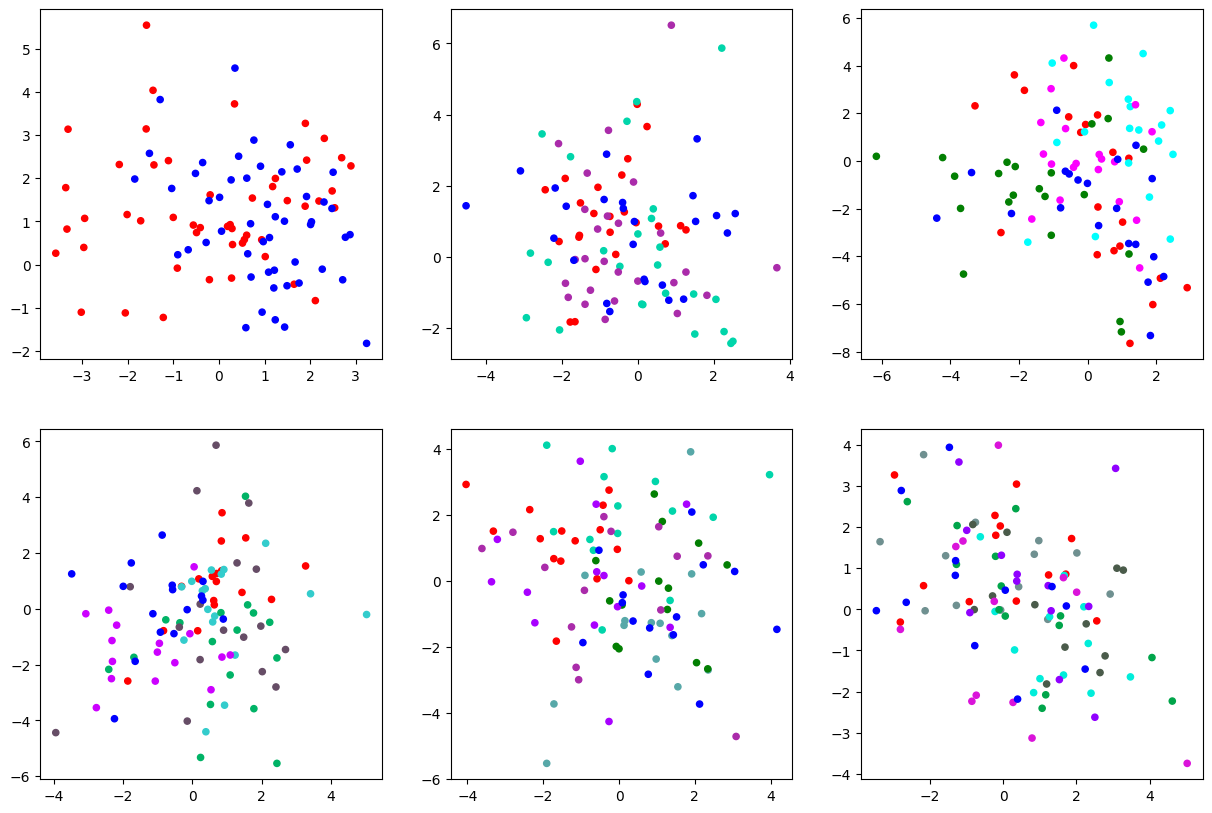

In [5]:
#color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","green","magenta","blue"])

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].scatter(x_b0[:,0], x_b0[:,1], c=y_b0, vmin=min(y_b0), vmax=max(y_b0), s=20, cmap=color_map_discrete)
axs[0, 1].scatter(x_b2[:,0], x_b2[:,1], c=y_b2, vmin=min(y_b2), vmax=max(y_b2), s=20, cmap=color_map_discrete)
axs[0, 2].scatter(x_b3[:,0], x_b3[:,1], c=y_b3, vmin=min(y_b3), vmax=max(y_b3), s=20, cmap=color_map_discrete)
axs[1, 0].scatter(x_b4[:,0], x_b4[:,1], c=y_b4, vmin=min(y_b4), vmax=max(y_b4), s=20, cmap=color_map_discrete)
axs[1, 1].scatter(x_b5[:,0], x_b5[:,1], c=y_b5, vmin=min(y_b5), vmax=max(y_b5), s=20, cmap=color_map_discrete)
axs[1, 2].scatter(x_b6[:,0], x_b6[:,1], c=y_b6, vmin=min(y_b6), vmax=max(y_b6), s=20, cmap=color_map_discrete)
plt.show

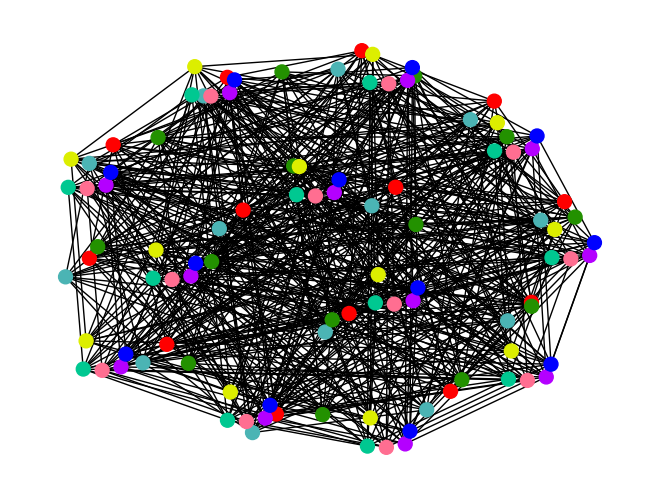

In [6]:
# if the graph is too big is better to don't plot it
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","green","yellow","magenta","blue"])

seed = 0
if(n_samples > 1000): # If are sure that you need this set a higher threshold
  print('This graph is going to take a big computational effort to be plot')
else:
  ## Plot the Graph
  def plot_sbm(G, seed):
    partition = community_louvain.best_partition(G, random_state=seed)
    pos = community_layout(G, partition, seed)
    nx.draw(G, pos, node_color=y_b, node_size=100, cmap=color_map_discrete)
    plt.savefig("Fid5.pdf")
    #files.download("Fid5.pdf")
    plt.show()

    #Community graph partitions
  def community_layout(g, partition, seed=0): # Compute the layout
    pos_communities = _position_communities(g, partition, scale=0.1, seed=seed)
    pos_nodes = _position_nodes(g, partition, scale=1, seed=seed)
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]
    return pos

    # Position of the communities
  def _position_communities(g, partition, **kwargs): # Create the graph
    between_community_edges = _find_between_community_edges(g, partition)
    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))
    pos_communities = nx.spring_layout(hypergraph, **kwargs)
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]
    return pos

    # Find community edges
  def _find_between_community_edges(g, partition):
    edges = dict()
    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]
        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]
    return edges

    # Position of the nodes
  def _position_nodes(g, partition, **kwargs):
    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]
    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)
    return pos

plot_sbm(G_sbm, seed)

# Apply the GAT

In [7]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1

        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, n_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GAT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

niter = 100
model.train()
loss_vtr = np.zeros(niter)
loss_vte = np.zeros(niter)
acc_tr_e = []
acc_te_e = []

for epoch in range(niter):
    model.train()
    optimizer.zero_grad()
    out = model(data.to(device))
    test=out[data.train_mask]

    loss_nll = F.nll_loss(test, data.y[data.train_mask])
    loss_nll.backward()
    optimizer.step()

    ########
    model.eval()
    loss_nll = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss_vtr[epoch] = loss_nll.item()

    # Calculate the accuracy for the train
    _, pred = out[data.train_mask].max(dim=1)
    correct = float(pred.eq(data.y[data.train_mask]).sum().item())
    acc_tr = correct / len(data.y[data.train_mask])

    # Calculate the loss for the test
    loss_nll = F.nll_loss(out[data.test_mask], data.y[data.test_mask])
    loss_vte[epoch] = loss_nll.item()

    # Calculate the accuracy for the test
    _, pred = out[data.test_mask].max(dim=1)
    correct = float(pred.eq(data.y[data.test_mask]).sum().item())
    acc_te = correct / len(data.y[data.test_mask])

    # Print the results by epoch
    if epoch%10 == 0:
        print('epoch: %d, loss_tr = %6.3f, loss_te = %6.3f, acc_tr = %6.3f, acc_te = %6.3f'
              % (epoch, loss_vtr[epoch], loss_vte[epoch], acc_tr, acc_te))

    # Save accuracy results
    acc_tr_e.append(acc_tr)
    acc_te_e.append(acc_te)

GATConv_acc_te=acc_te
print('%6.4f'%GATConv_acc_te)

epoch: 0, loss_tr =  4.428, loss_te =  4.488, acc_tr =  0.141, acc_te =  0.250
epoch: 10, loss_tr =  6.726, loss_te =  5.975, acc_tr =  0.141, acc_te =  0.139
epoch: 20, loss_tr =  4.381, loss_te =  3.080, acc_tr =  0.125, acc_te =  0.167
epoch: 30, loss_tr =  3.343, loss_te =  2.515, acc_tr =  0.188, acc_te =  0.139
epoch: 40, loss_tr =  2.034, loss_te =  2.233, acc_tr =  0.219, acc_te =  0.222
epoch: 50, loss_tr =  2.544, loss_te =  2.225, acc_tr =  0.188, acc_te =  0.250
epoch: 60, loss_tr =  1.502, loss_te =  1.644, acc_tr =  0.469, acc_te =  0.417
epoch: 70, loss_tr =  2.362, loss_te =  2.081, acc_tr =  0.359, acc_te =  0.167
epoch: 80, loss_tr =  1.645, loss_te =  1.640, acc_tr =  0.359, acc_te =  0.278
epoch: 90, loss_tr =  1.891, loss_te =  2.449, acc_tr =  0.297, acc_te =  0.222
0.2500


<function matplotlib.pyplot.show(close=None, block=None)>

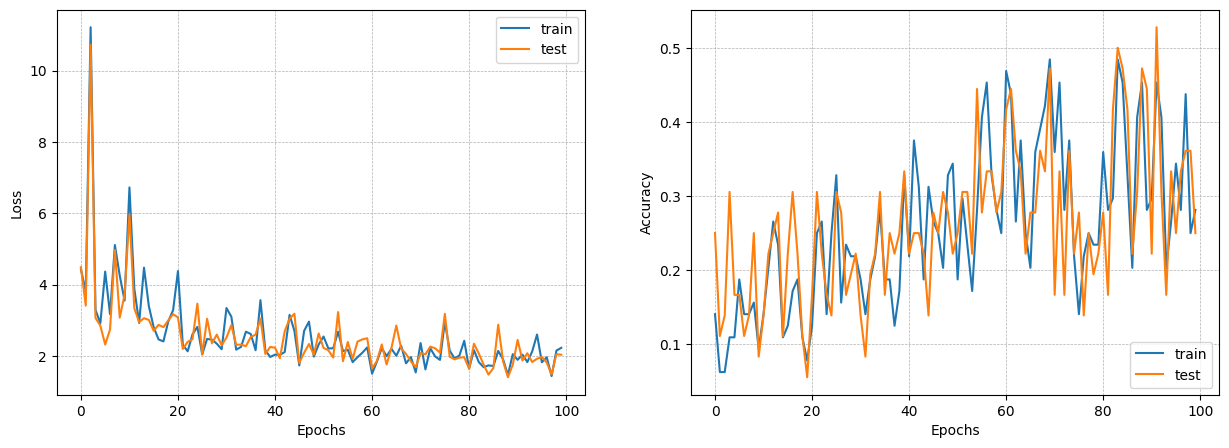

In [8]:
# Plot the convergence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(loss_vtr, zorder=2)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epochs')
ax1.grid(linestyle = '--', linewidth = 0.5, zorder=0)
# The test loss looks like the train loss
ax1.plot(loss_vte)
ax1.legend(["train", "test"], loc="upper right")
plt.show


ax2.plot(acc_tr_e, zorder=2)
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epochs')
ax2.grid(linestyle = '--', linewidth = 0.5, zorder=0)
# The test loss looks like the train loss
ax2.plot(acc_te_e)
ax2.legend(["train", "test"], loc="lower right")
plt.savefig("Fid.pdf")
#files.download("Fid.pdf")
plt.show

# Apply the GCN

In [9]:
from torch_geometric.nn import GCNConv

# GCN model with 2 layers
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(data.num_features, 16)                               # I have applied GCN instead of GAT
        self.conv2 = GCNConv(16, n_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)                                                              # I was using a relu activation function
        x = F.dropout(x, p=0.6, training=self.training)                           # I was not using this p = 0.6
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

niter = 100
loss_vtr = np.zeros(niter)
loss_vte = np.zeros(niter)
acc_tr_e = []
acc_te_e = []

for epoch in range(niter):
    model.train()
    optimizer.zero_grad()
    out = model(data.to(device))
    loss_nll = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss_nll.backward()
    optimizer.step()

    ########
    model.eval()
    loss_nll = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss_vtr[epoch] = loss_nll.item()

    # Calculate the accuracy for the train
    _, pred = out[data.train_mask].max(dim=1)
    correct = float(pred.eq(data.y[data.train_mask]).sum().item())
    acc_tr = correct / len(data.y[data.train_mask])
    # acc_tr = float(pred.eq(data.y[data.train_mask]).sum().item()) / data.train_mask.sum().item() I have calculated different but it works the same

    # Calculate the loss for the test
    loss_nll = F.nll_loss(out[data.test_mask], data.y[data.test_mask])            # I was not evaluating the loss in the testing
    loss_vte[epoch] = loss_nll.item()

    # Calculate the accuracy for the test
    _, pred = out[data.test_mask].max(dim=1)
    correct = float(pred.eq(data.y[data.test_mask]).sum().item())
    acc_te = correct / len(data.y[data.test_mask])

    # Print the results by epoch
    if epoch%10 == 0:
        print('epoch: %d, loss_tr = %6.3f, loss_te = %6.3f, acc_tr = %6.3f, acc_te = %6.3f'
              % (epoch, loss_vtr[epoch], loss_vte[epoch], acc_tr, acc_te))

    # Save accuracy results
    acc_tr_e.append(acc_tr)
    acc_te_e.append(acc_te)

GCNConv_acc_te=acc_te

epoch: 0, loss_tr =  3.102, loss_te =  3.118, acc_tr =  0.141, acc_te =  0.167
epoch: 10, loss_tr =  2.467, loss_te =  2.721, acc_tr =  0.109, acc_te =  0.083
epoch: 20, loss_tr =  2.108, loss_te =  2.122, acc_tr =  0.234, acc_te =  0.250
epoch: 30, loss_tr =  2.774, loss_te =  2.748, acc_tr =  0.125, acc_te =  0.139
epoch: 40, loss_tr =  1.712, loss_te =  1.742, acc_tr =  0.328, acc_te =  0.361
epoch: 50, loss_tr =  2.492, loss_te =  2.371, acc_tr =  0.047, acc_te =  0.056
epoch: 60, loss_tr =  1.291, loss_te =  1.346, acc_tr =  0.469, acc_te =  0.472
epoch: 70, loss_tr =  1.234, loss_te =  1.265, acc_tr =  0.609, acc_te =  0.556
epoch: 80, loss_tr =  1.157, loss_te =  1.054, acc_tr =  0.469, acc_te =  0.639
epoch: 90, loss_tr =  1.127, loss_te =  1.180, acc_tr =  0.562, acc_te =  0.417


<function matplotlib.pyplot.show(close=None, block=None)>

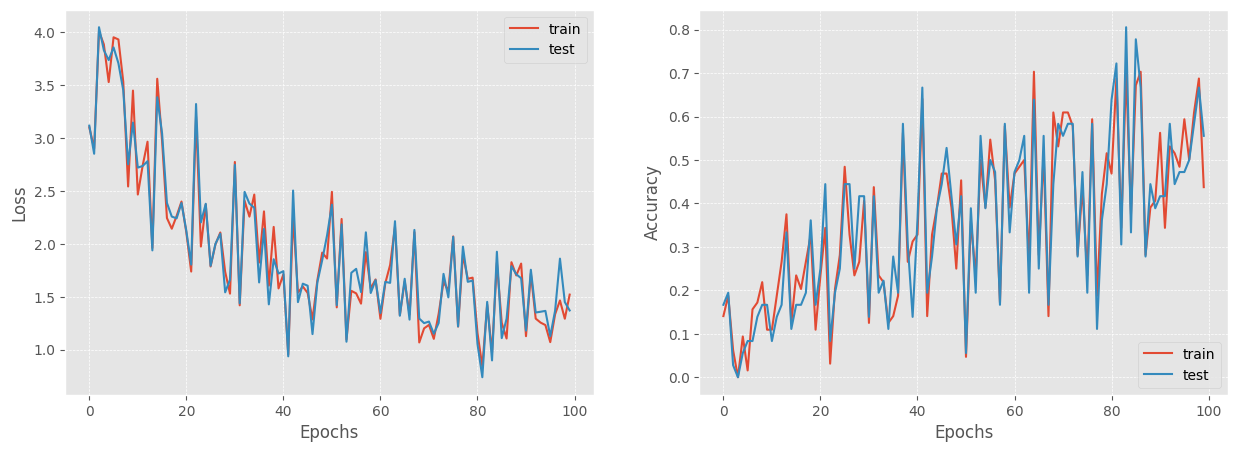

In [12]:
# Plot the convergence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(loss_vtr, zorder=2)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epochs')
ax1.grid(linestyle = '--', linewidth = 0.5, zorder=0)
# The test loss looks like the train loss
ax1.plot(loss_vte)
ax1.legend(["train", "test"], loc="upper right")
plt.show


ax2.plot(acc_tr_e, zorder=2)
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epochs')
ax2.grid(linestyle = '--', linewidth = 0.5, zorder=0)
# The test loss looks like the train loss
ax2.plot(acc_te_e)
ax2.legend(["train", "test"], loc="lower right")
plt.savefig("Fid.pdf")
#files.download("Fid.pdf")
plt.show

# Compare to other classification methods

In [10]:
plt.style.use('ggplot')

X=x_b
y=y_b

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1-per_train))
kfold = model_selection.KFold(n_splits=10, random_state=None)

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

results = []
names = []
scoring = 'accuracy'
for name, model in models:
      kfold = model_selection.KFold(n_splits=10, random_state=None)
      cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
      results.append(cv_results)
      names.append(name)
      msg = "%s: %1.2f" % (name, 100*cv_results.mean())
      print(f'{msg} &')

print("GCNConv: %1.2f &"% (100*GCNConv_acc_te))
print("GATConv: %1.2f &"% (100*GATConv_acc_te))

LR: 17.86 &
LDA: 16.43 &
KNN: 17.38 &
CART: 13.10 &
NB: 14.76 &
SVM: 14.52 &
GCNConv: 55.56 &
GATConv: 25.00 &


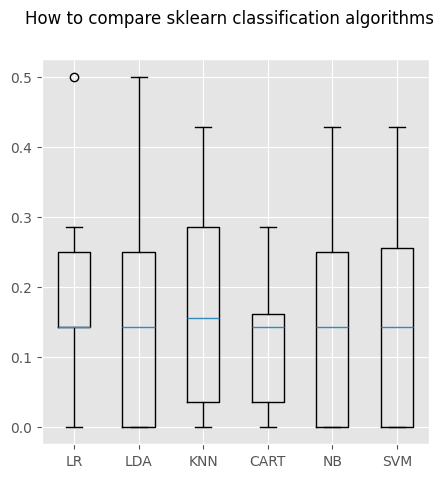

In [11]:
fig = plt.figure(figsize=(5,5))
fig.suptitle('How to compare sklearn classification algorithms')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()